In [1]:
import tensorflow as tf

In [2]:
import numpy as np

subject = '25'
# start_path = f'/Volumes/bci_pi_shared/home/bcipi/DEV/bci_project/src/eye_state_testing/S{subject}/'
start_path = f'../RaspberryPi_Code/DataSet/S{subject}/'
# Load the EEG data from the files
file_raw = f'{start_path}X_raw_S{subject}.npy'

file_y = f'{start_path}Y_S{subject}.npy'

X_preprocessing = np.load(file_raw)
y_preprocessing = np.load(file_y)

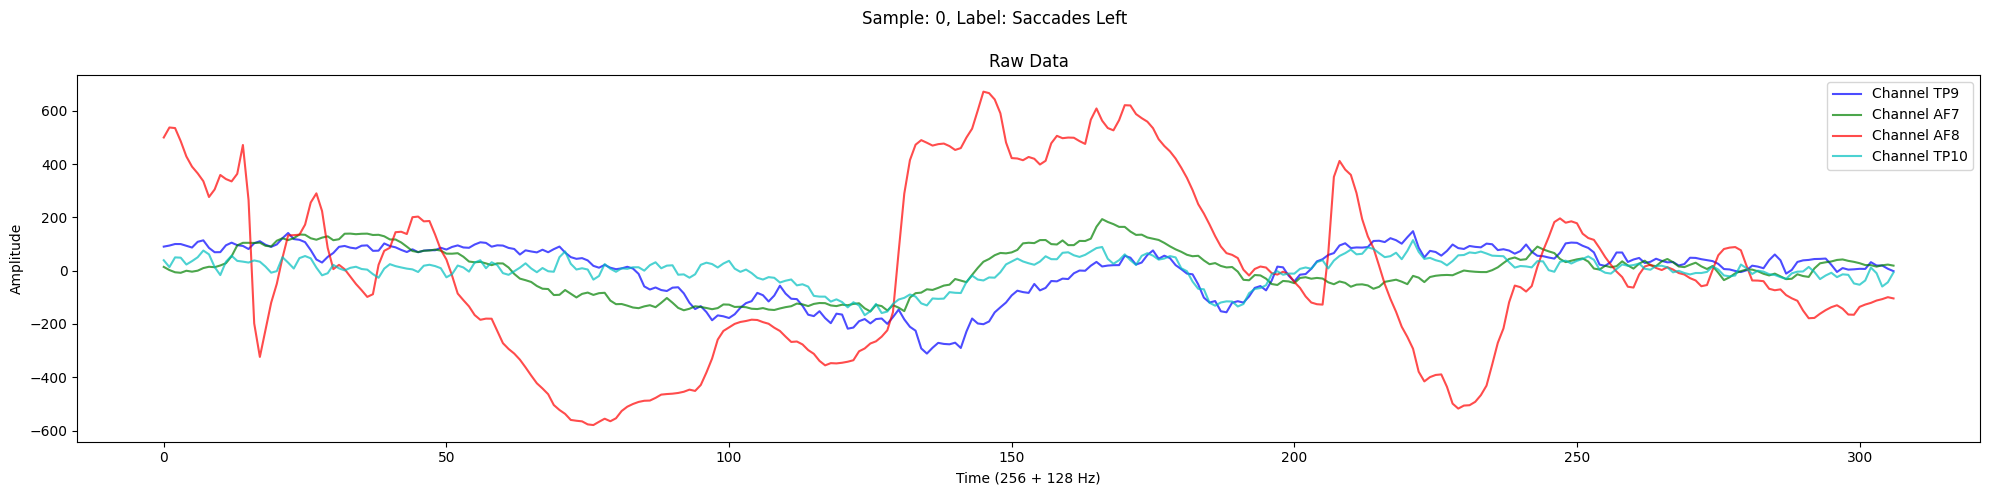

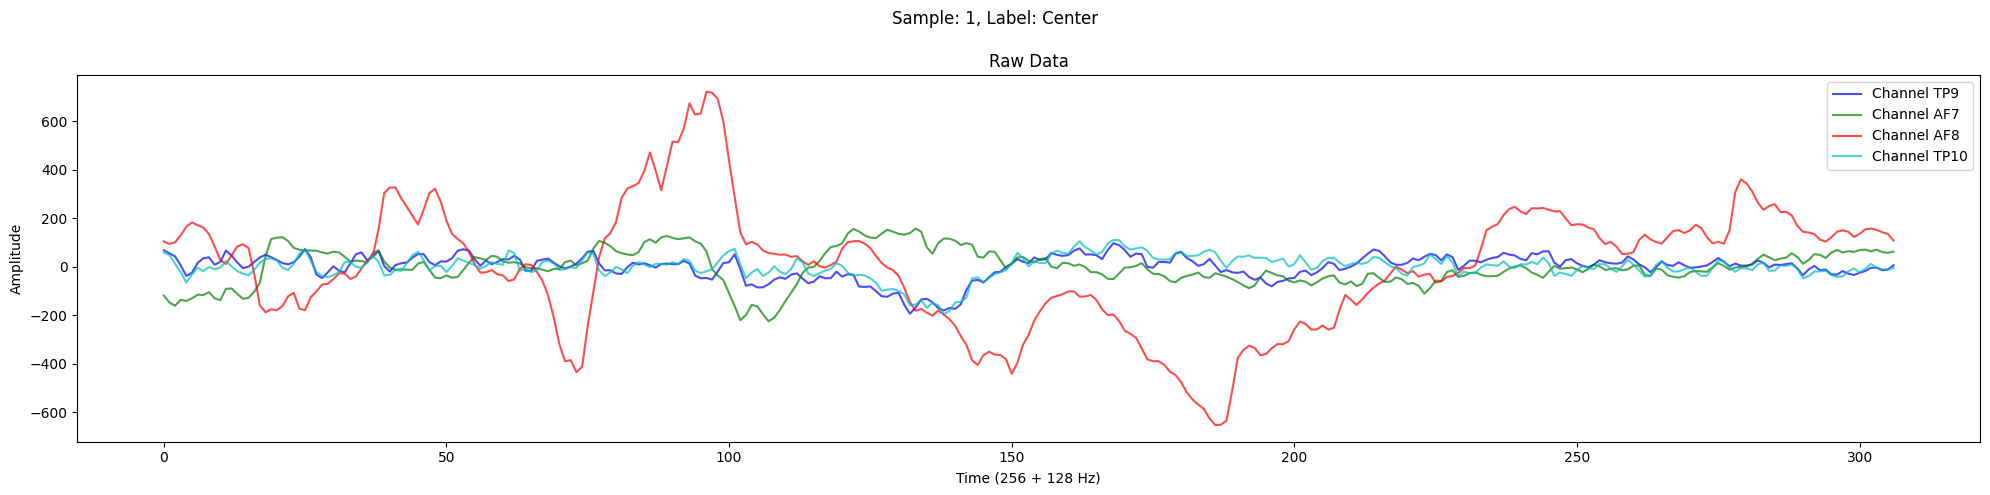

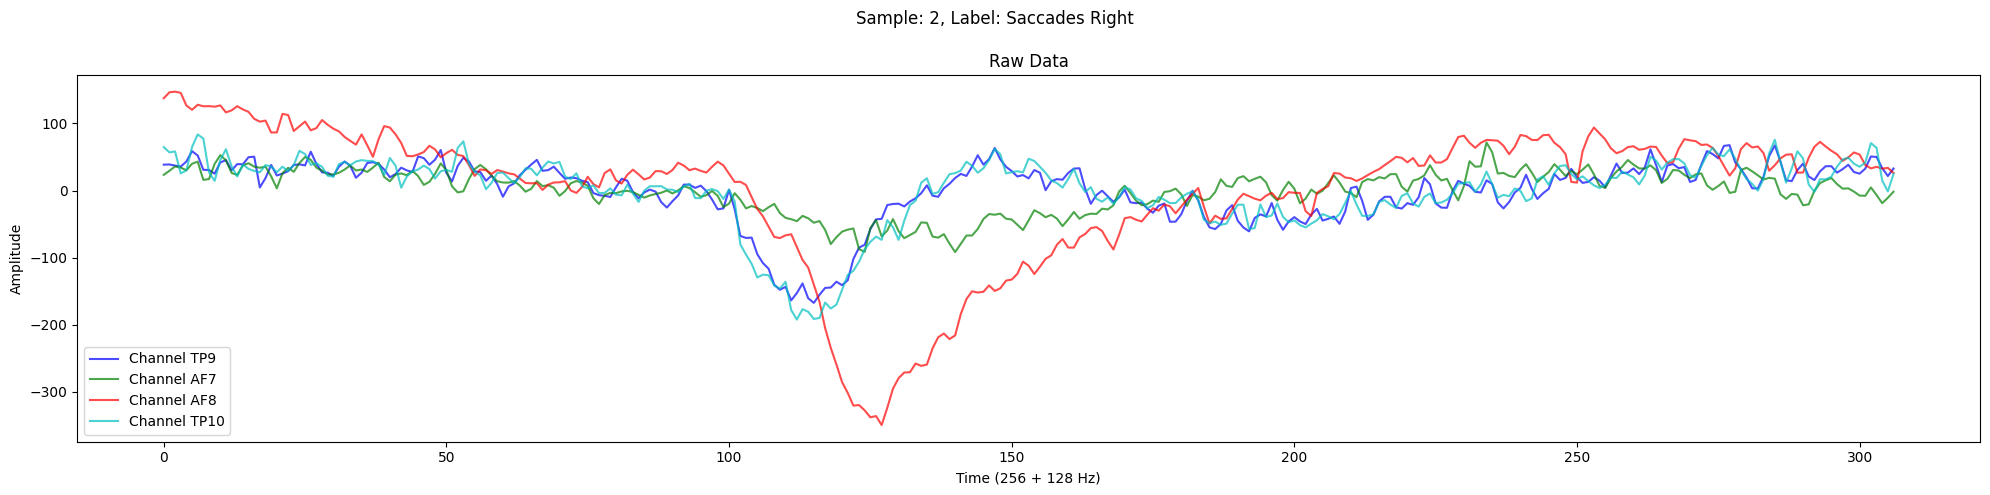

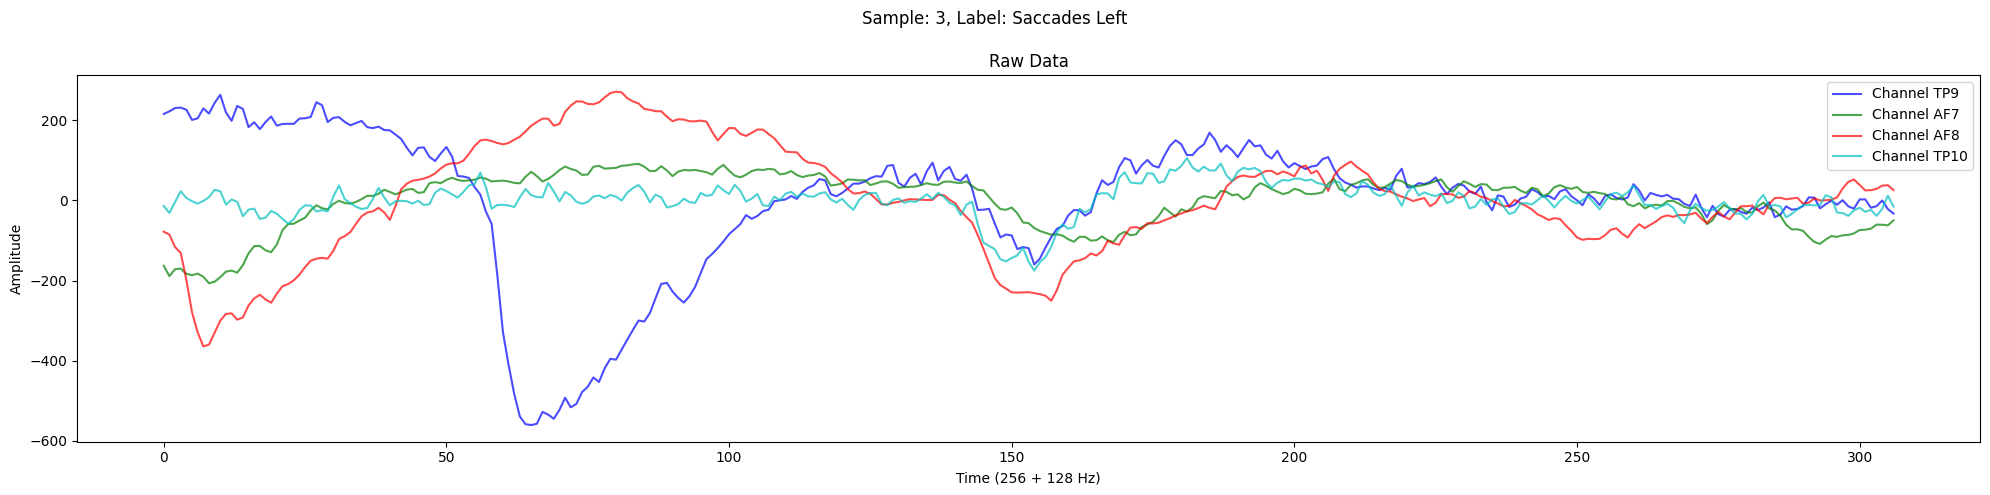

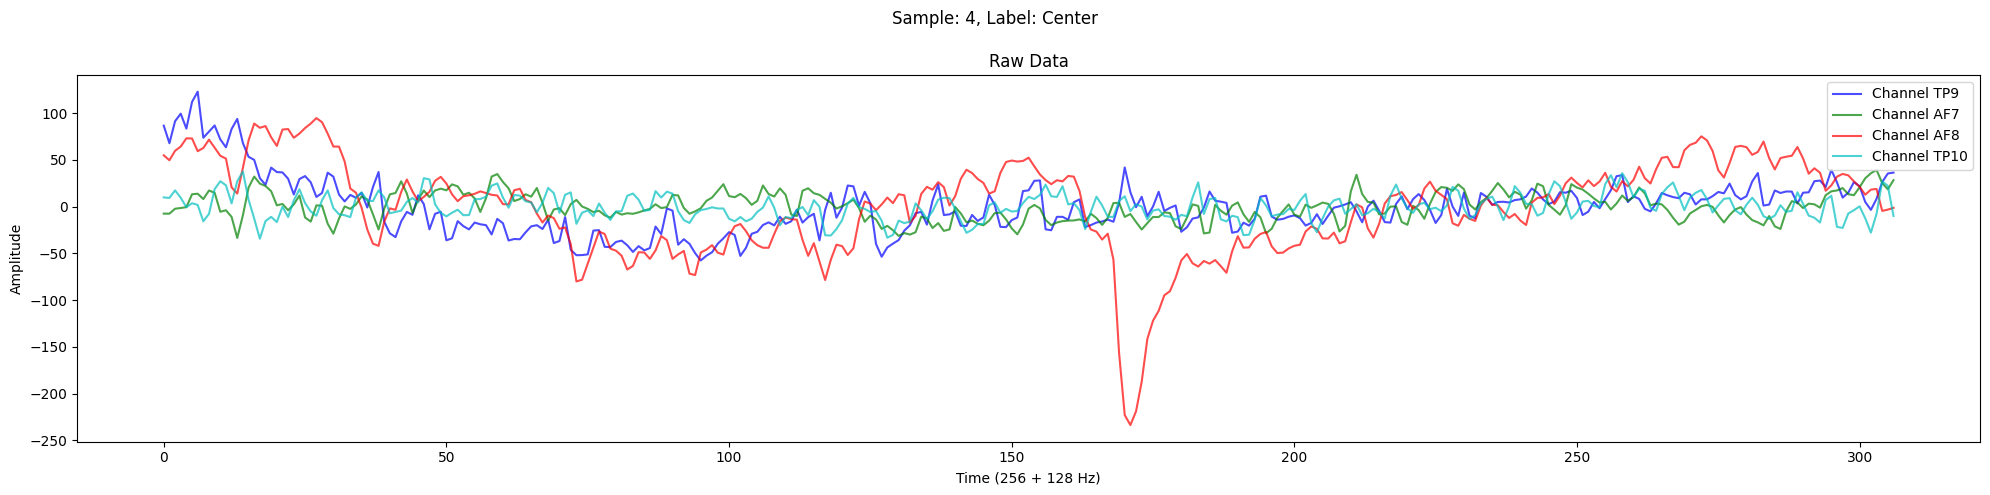

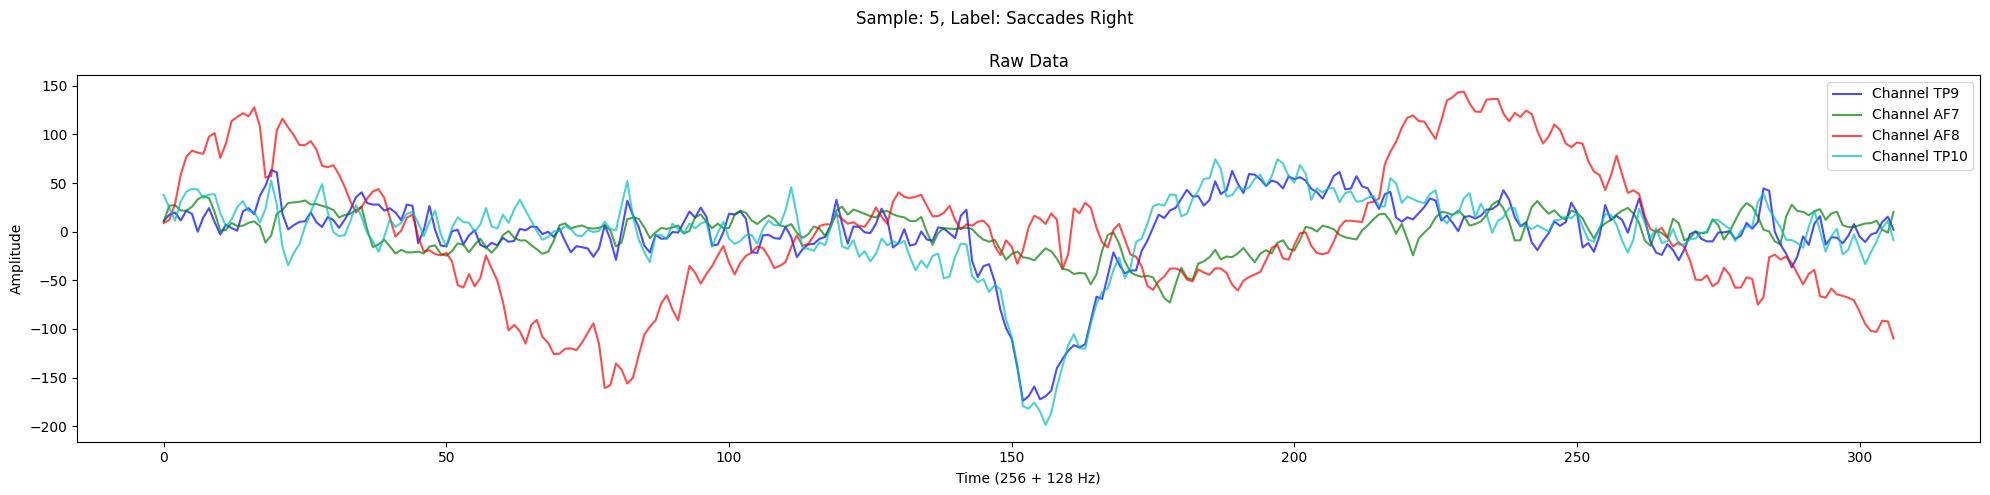

In [3]:
import matplotlib.pyplot as plt

index = 0
n_show = 0

# ชื่อช่วงความถี่
# frequency_bands = ['Raw', 'Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
frequency_bands = ['Raw']

# สีสำหรับแต่ละช่องสัญญาณ (ปรับตามความต้องการ)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'brown', 'gray', 'olive', 'cyan']
channel = ['TP9', 'AF7', 'AF8', 'TP10']
# channel = ['AF7', 'AF8']

while index < y_preprocessing.shape[0]:
    if n_show <= 5:
        fig, ax = plt.subplots(figsize=(20, 5))  # ใช้ subplot เดียวสำหรับข้อมูล raw
        fig.suptitle(f"Sample: {index}, Label: {y_preprocessing[index]}")

        for j in range(4):  # ลูปผ่านช่องสัญญาณ 4 ช่อง
            ax.plot(X_preprocessing[index, :, j], alpha=0.7, color=colors[j % len(colors)], label=f'Channel {channel[j % 4]}')

        ax.set_title(f'Raw Data')
        ax.set_xlabel('Time (256 + 128 Hz)')
        ax.set_ylabel('Amplitude')
        ax.legend()

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)  # adjust the top spacing to make room for the main title
        plt.show()
        print(f"{100*'=='}")
        n_show += 1
    index += 1

In [4]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import pandas as pd

label_encoder = LabelEncoder()
encoded_data = label_encoder.fit_transform(y_preprocessing)

one_encoded_data = to_categorical(encoded_data, num_classes=3)  # แปลงเป็น one-hot encoding
# ดูค่าที่แปลงแล้ว
# print("Encoded values:", encoded_data)
# print("One Encoded values:", one_encoded_data)
# สร้างตารางเพื่อดูค่าที่แปลงแล้วและค่าที่แท้จริง
label_mapping = pd.DataFrame({'Original Value': label_encoder.classes_, 'Encoded Value': range(len(label_encoder.classes_))})
print(label_mapping)

   Original Value  Encoded Value
0          Center              0
1   Saccades Left              1
2  Saccades Right              2


In [5]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model


def build_eeg_classification_model(input_shape, num_classes):
    # Define the input layers for the three frequency bands
    Input_layer = Input(shape=input_shape)

    Conv1D_layer = Conv1D(filters=128, kernel_size=1, activation='relu')(Input_layer)
    LSTM_layer = LSTM(128, dropout=0.2, recurrent_regularizer=l2(0.001))(Conv1D_layer)
    Output_layer = Dense(num_classes, activation='softmax')(LSTM_layer)

    # Define the model
    model = Model(inputs=Input_layer, outputs=Output_layer)

    # กำหนด optimizer
    learning_rate = 0.001
    optimizer = Adam(learning_rate=learning_rate)
    # คอมไพล์โมเดล
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Initialize variables for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_model = None
best_val_accuracy = 0
history_list = []

# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_preprocessing), start=1):
    X_train, X_val = X_preprocessing[train_index], X_preprocessing[val_index]
    y_train, y_val = one_encoded_data[train_index], one_encoded_data[val_index]

    model = build_eeg_classification_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=3)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=300,
        batch_size=4,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Fold {fold} - Validation accuracy: {val_accuracy:.4f}")

    # Save history for the current fold
    history_list.append(history.history)

    # Save the model if it's the best so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model
        best_history = history

# Save the best model
folder_name = os.path.join(start_path, f"model_results_S{subject}")
os.makedirs(folder_name, exist_ok=True)

# Save the best model
model_filename = os.path.join(folder_name, "eeg_model.h5")
best_model.save(model_filename)

# Evaluate the best model on the test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X_preprocessing, one_encoded_data, test_size=0.4, random_state=42, shuffle=True
)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True
)
y_test_pred = best_model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

# Save the confusion matrix
cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)
cm_filename = os.path.join(folder_name, "confusion_matrix.png")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping["Original Value"], yticklabels=label_mapping["Original Value"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Test Set')
plt.savefig(cm_filename)
plt.close()

# Save the classification report
report_filename = os.path.join(folder_name, "classification_report.txt")
report = classification_report(y_test_true_classes, y_test_pred_classes, target_names=label_mapping["Original Value"])
with open(report_filename, "w") as f:
    f.write(report)

# Save the learning curve
learning_curve_filename = os.path.join(folder_name, "learning_curve.png")
plt.plot(best_history.history['accuracy'])
plt.plot(best_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(learning_curve_filename)
plt.close()

# Save the loss curve
loss_curve_filename = os.path.join(folder_name, "loss_curve.png")
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(loss_curve_filename)
plt.close()

# Save the model architecture
model_architecture_filename = os.path.join(folder_name, "model_architecture.png")
plot_model(best_model, to_file=model_architecture_filename, show_shapes=True)

print(f"Results saved to folder: {folder_name}")



2024-08-29 00:55:01.701812: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-29 00:55:01.701836: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-29 00:55:01.701843: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-29 00:55:01.702531: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-29 00:55:01.702855: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/300


2024-08-29 00:55:03.415784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-29 00:55:03.724867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-29 00:55:03.925627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/18 [===========================>..] - ETA: 0s - loss: 1.4247 - accuracy: 0.3529

2024-08-29 00:55:05.173405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-29 00:55:05.289055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 3s 83ms/step - loss: 1.4064 - accuracy: 0.3472 - val_loss: 1.1991 - val_accuracy: 0.4444
Epoch 2/300
18/18 [==============================] - 1s 50ms/step - loss: 0.9069 - accuracy: 0.6528 - val_loss: 1.2114 - val_accuracy: 0.3889
Epoch 3/300
18/18 [==============================] - 1s 50ms/step - loss: 0.7524 - accuracy: 0.7222 - val_loss: 1.1083 - val_accuracy: 0.4444
Epoch 4/300
18/18 [==============================] - 1s 51ms/step - loss: 0.6432 - accuracy: 0.7917 - val_loss: 1.0615 - val_accuracy: 0.5000
Epoch 5/300
18/18 [==============================] - 1s 51ms/step - loss: 0.5728 - accuracy: 0.8750 - val_loss: 0.9848 - val_accuracy: 0.3333
Epoch 6/300
18/18 [==============================] - 1s 49ms/step - loss: 0.5342 - accuracy: 0.8889 - val_loss: 1.0450 - val_accuracy: 0.5556
Epoch 7/300
18/18 [==============================] - 1s 52ms/step - loss: 0.4846 - accuracy: 0.8889 - val_loss: 1.0238 - val_accuracy: 0.5556
Epoch 8/300
18/18 

Epoch 1/300


2024-08-29 00:55:19.562458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-29 00:55:19.843376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-29 00:55:19.973150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/18 [===========================>..] - ETA: 0s - loss: 1.3301 - accuracy: 0.3824

2024-08-29 00:55:21.157023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-29 00:55:21.266890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 3s 79ms/step - loss: 1.3273 - accuracy: 0.4028 - val_loss: 1.2711 - val_accuracy: 0.2222
Epoch 2/300
18/18 [==============================] - 1s 51ms/step - loss: 0.9077 - accuracy: 0.6111 - val_loss: 1.2049 - val_accuracy: 0.3889
Epoch 3/300
18/18 [==============================] - 1s 51ms/step - loss: 0.7210 - accuracy: 0.7222 - val_loss: 1.3507 - val_accuracy: 0.4444
Epoch 4/300
18/18 [==============================] - 1s 51ms/step - loss: 0.5856 - accuracy: 0.8611 - val_loss: 1.3025 - val_accuracy: 0.2778
Epoch 5/300
18/18 [==============================] - 1s 53ms/step - loss: 0.5078 - accuracy: 0.8889 - val_loss: 1.3466 - val_accuracy: 0.5000
Epoch 6/300
18/18 [==============================] - 1s 50ms/step - loss: 0.4908 - accuracy: 0.8750 - val_loss: 1.2883 - val_accuracy: 0.3333
Epoch 7/300
18/18 [==============================] - 1s 49ms/step - loss: 0.3746 - accuracy: 0.9028 - val_loss: 1.4566 - val_accuracy: 0.3889
Epoch 8/300
18/18 

Epoch 1/300


2024-08-29 00:55:33.020038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-29 00:55:33.290619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-29 00:55:33.427899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/18 [===========================>..] - ETA: 0s - loss: 1.2859 - accuracy: 0.4559

2024-08-29 00:55:34.623305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-29 00:55:34.731223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 3s 80ms/step - loss: 1.2864 - accuracy: 0.4444 - val_loss: 1.1065 - val_accuracy: 0.5000
Epoch 2/300
18/18 [==============================] - 1s 52ms/step - loss: 1.0104 - accuracy: 0.5833 - val_loss: 1.2557 - val_accuracy: 0.4444
Epoch 3/300
18/18 [==============================] - 1s 51ms/step - loss: 0.8655 - accuracy: 0.6389 - val_loss: 1.1628 - val_accuracy: 0.5556
Epoch 4/300
18/18 [==============================] - 1s 53ms/step - loss: 0.7533 - accuracy: 0.7361 - val_loss: 1.0381 - val_accuracy: 0.5000
Epoch 5/300
18/18 [==============================] - 1s 51ms/step - loss: 0.6219 - accuracy: 0.8333 - val_loss: 1.1112 - val_accuracy: 0.5556
Epoch 6/300
18/18 [==============================] - 1s 51ms/step - loss: 0.5002 - accuracy: 0.8472 - val_loss: 1.1495 - val_accuracy: 0.4444
Epoch 7/300
18/18 [==============================] - 1s 52ms/step - loss: 0.5120 - accuracy: 0.8333 - val_loss: 1.1276 - val_accuracy: 0.3889
Epoch 8/300
18/18 

Epoch 1/300


2024-08-29 00:55:48.169225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-29 00:55:48.455493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-29 00:55:48.604785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1.4339 - accuracy: 0.2639

2024-08-29 00:55:49.821460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-29 00:55:49.929394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 3s 82ms/step - loss: 1.4339 - accuracy: 0.2639 - val_loss: 1.2232 - val_accuracy: 0.3889
Epoch 2/300
18/18 [==============================] - 1s 51ms/step - loss: 0.9637 - accuracy: 0.5556 - val_loss: 1.1563 - val_accuracy: 0.4444
Epoch 3/300
18/18 [==============================] - 1s 50ms/step - loss: 0.8715 - accuracy: 0.6528 - val_loss: 1.2133 - val_accuracy: 0.2778
Epoch 4/300
18/18 [==============================] - 1s 55ms/step - loss: 0.6719 - accuracy: 0.8194 - val_loss: 1.1446 - val_accuracy: 0.5000
Epoch 5/300
18/18 [==============================] - 1s 56ms/step - loss: 0.6736 - accuracy: 0.7917 - val_loss: 1.1317 - val_accuracy: 0.3333
Epoch 6/300
18/18 [==============================] - 1s 52ms/step - loss: 0.5773 - accuracy: 0.8333 - val_loss: 1.1175 - val_accuracy: 0.4444
Epoch 7/300
18/18 [==============================] - 1s 50ms/step - loss: 0.5001 - accuracy: 0.8750 - val_loss: 0.9936 - val_accuracy: 0.5000
Epoch 8/300
18/18 

Epoch 1/300


2024-08-29 00:56:16.556788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-29 00:56:16.834337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-29 00:56:16.971210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/18 [===========================>..] - ETA: 0s - loss: 1.3351 - accuracy: 0.3676

2024-08-29 00:56:18.248271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-29 00:56:18.370352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 3s 87ms/step - loss: 1.3458 - accuracy: 0.3611 - val_loss: 1.6058 - val_accuracy: 0.2222
Epoch 2/300
18/18 [==============================] - 1s 56ms/step - loss: 1.0638 - accuracy: 0.5000 - val_loss: 1.2050 - val_accuracy: 0.4444
Epoch 3/300
18/18 [==============================] - 1s 56ms/step - loss: 0.8316 - accuracy: 0.7361 - val_loss: 1.3089 - val_accuracy: 0.2778
Epoch 4/300
18/18 [==============================] - 1s 58ms/step - loss: 0.6976 - accuracy: 0.7917 - val_loss: 1.1717 - val_accuracy: 0.5556
Epoch 5/300
18/18 [==============================] - 1s 52ms/step - loss: 0.7011 - accuracy: 0.7778 - val_loss: 1.2485 - val_accuracy: 0.3889
Epoch 6/300
18/18 [==============================] - 1s 53ms/step - loss: 0.5781 - accuracy: 0.8194 - val_loss: 1.3234 - val_accuracy: 0.3889
Epoch 7/300
18/18 [==============================] - 1s 54ms/step - loss: 0.5548 - accuracy: 0.8333 - val_loss: 1.3178 - val_accuracy: 0.3889
Epoch 8/300
18/18 

/Users/jiraphat/miniforge3/envs/mind_project/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2024-08-29 00:56:32.077474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-29 00:56:32.174389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 743ms/step
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Results saved to folder: ../RaspberryPi_Code/DataSet/S25/model_results_S25
